In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import numpy as np
from os import listdir
import pickle
from astropy.io import fits
%matplotlib inline

In [15]:
def load_img(file):
    """
    加载图像，dat和fits均支持，不过仅支持CxHxW
    :param filename: 传入文件名，应当为CHW
    :return: 返回CHW的ndarray
    """
    if ".fits" in file:
        with fits.open(file) as hdul:
            return hdul[0].data.astype(np.float32)
    else:
        raise TypeError

def chw2hwc(img):
    ch1, ch2, ch3 = img[0], img[1], img[2]
    h, w = ch1.shape
    return np.concatenate((ch1.reshape(h, w, 1), ch2.reshape(h, w, 1), ch3.reshape(h, w, 1)), axis=2)

def hwc2chw(img):
    ch1, ch2, ch3 = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    return np.array((ch1, ch2, ch3))

In [21]:
plt_path = "/data/renhaoye/decals_2022/code/plt/"

In [22]:
raw_fits = listdir("/data/renhaoye/decals_2022/in_decals/fits/")

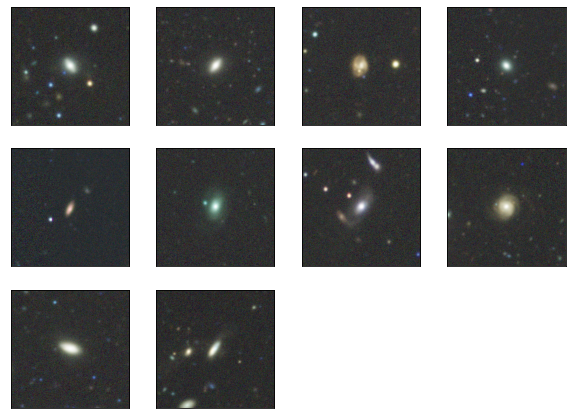

In [23]:
data_dir = "/data/renhaoye/decals_2022/in_decals/decals_best/"
plt.figure(figsize=(10, 10))
for i in range(10):
    img = chw2hwc(load_img(data_dir + raw_fits[i]))
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
plt.savefig(plt_path + "data.jpg")
plt.show()